# Bayse Model 負の二項分布

In [1]:
import os
os.environ['PYTENSOR_FLAGS'] = 'blas_ldflags='

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
import jax
jax.config.update("jax_platform_name", "cpu")
import jax.numpy as jnp
import pymc as pm
import arviz as az
from graphviz import Digraph

/home/keisei/data-analysis/bridge-straw-effects/.venv/lib/python3.10/site-packages/pytensor/configparser.py:320: UserWarning: PyTensor does not recognise this flag: blas_ldflags
  warnings.warn(f"PyTensor does not recognise this flag: {key}")


In [3]:
filepath = "../../../../data/processed/df_filtered_5years.xlsx"
df = pd.read_excel(filepath)
df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()
df['log_income'] = np.log(df['income'])
df = df.dropna()

/tmp/ipykernel_10859/3407249749.py:3: FutureWarning: The default fill_method='ffill' in SeriesGroupBy.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['population_change_rate'] = df.groupby('island_id')['population'].pct_change()


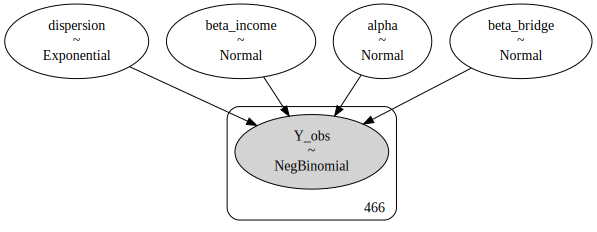

In [16]:
population = df['population'].values
bridge = df['dummy_after_bridge_opened'].values
log_income = df['log_income'].values

mean_population = np.mean(population)
lambda_value = 1 / mean_population

with pm.Model() as model:
    # 事前分布
    alpha = pm.Normal('alpha', mu=12.8230, sigma=100)
    beta_bridge = pm.Normal('beta_bridge', mu=2.2547, sigma=100)
    beta_income = pm.Normal('beta_income', mu=-0.3519, sigma=100)
    dispersion = pm.Exponential('dispersion', lam=lambda_value)

    # 対数リンク関数
    lambda_ = pm.math.exp(alpha + beta_bridge * bridge + beta_income * log_income)

    # 尤度
    Y_obs = pm.NegativeBinomial('Y_obs', mu=lambda_, alpha=dispersion, observed=population)

# モデルの視覚化
graph = pm.model_to_graphviz(model)
graph.render(filename='../../visualization/graphviz/bm_t_5years', format='png', cleanup=True)
graph

In [20]:
with model:
    idata = pm.sample(
        draws=5000,
        tune=1000,
        nuts_sampler="numpyro",
        return_inferencedata=True,
    )


  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

  0%|          | 0/6000 [00:00<?, ?it/s]

In [21]:
az.to_netcdf(idata, '../../mcmc_results/bm_negative_binomial_5years.nc')

'../../mcmc_results/bm_negative_binomial_5years.nc'

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,13.607,0.791,12.116,15.111,0.009,0.006,7784.0,9054.0,1.0
beta_bridge,2.369,0.171,2.044,2.686,0.002,0.001,11779.0,10845.0,1.0
beta_income,-0.395,0.045,-0.482,-0.312,0.001,0.000,7741.0,8991.0,1.0
dispersion,0.392,0.021,0.352,0.430,0.000,0.000,11729.0,10667.0,1.0


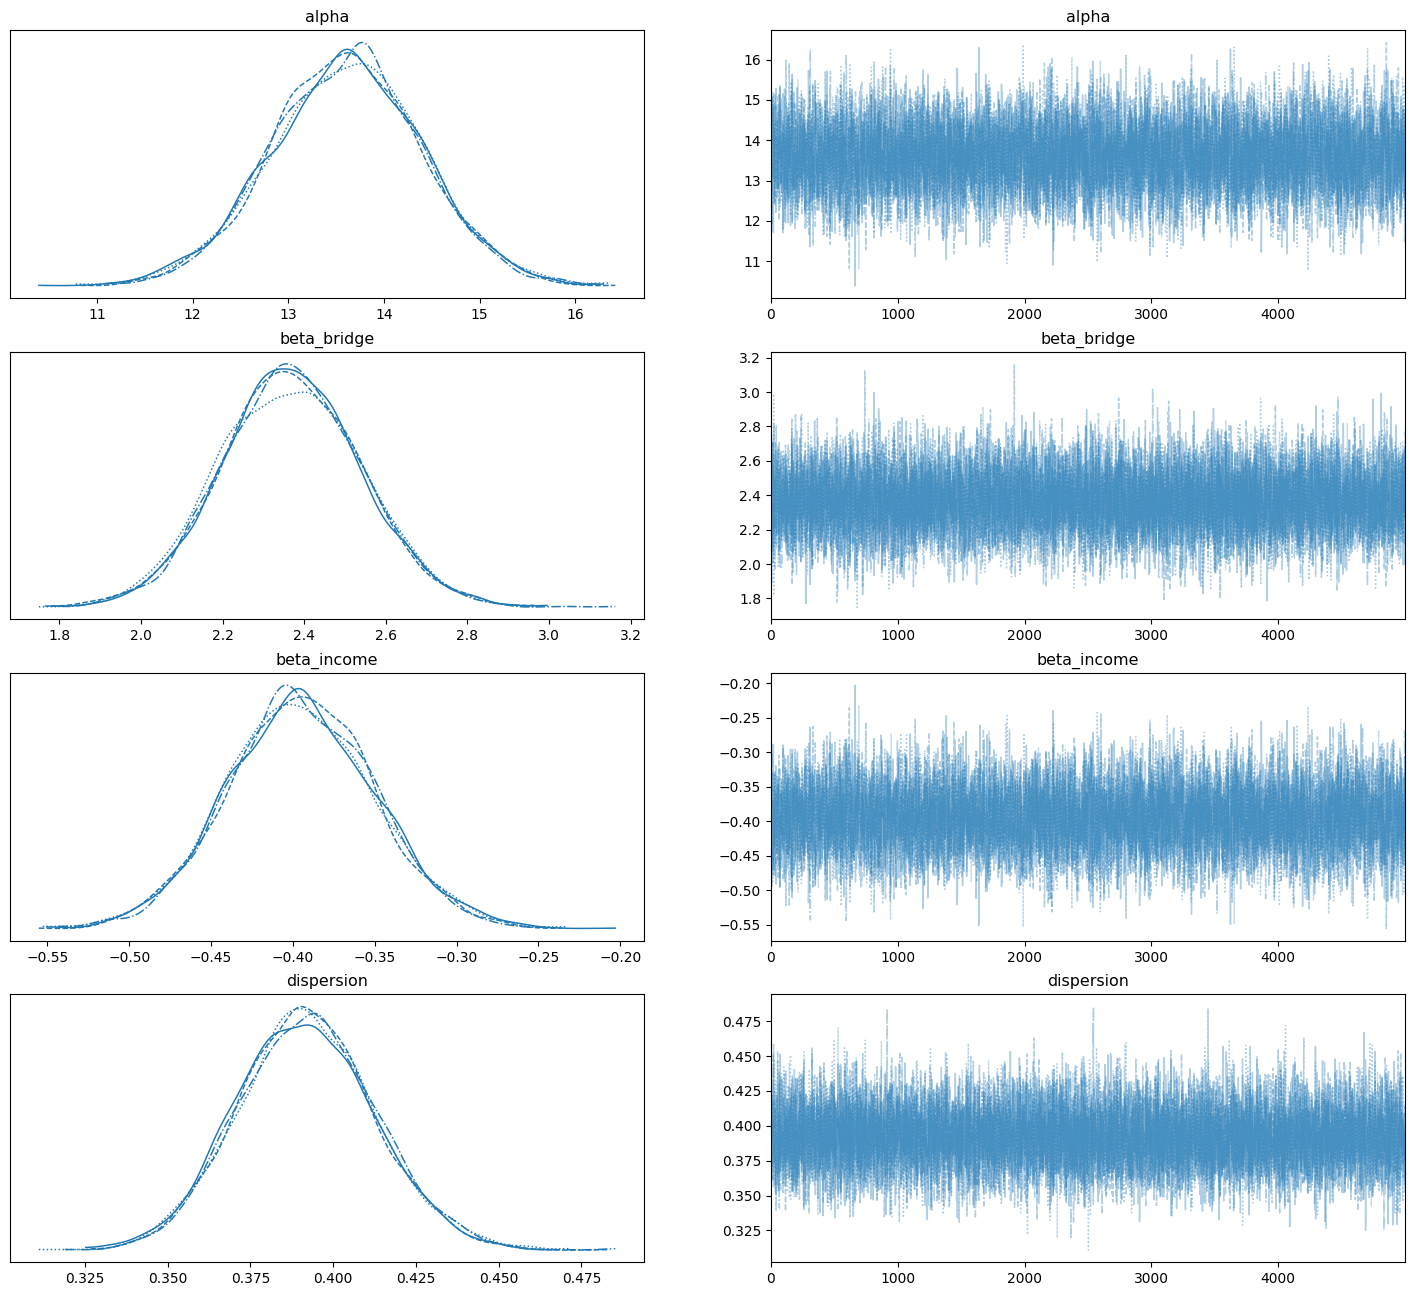

In [22]:
az.plot_trace(idata, figsize=(18, 16))  # サイズを調整
az.summary(idata)

# 橋ダミーのパラメータが0以上である確率

In [55]:
posterior_samples = idata.posterior

beta_bridge_samples = posterior_samples['beta_bridge']

# 0以上のサンプルの割合を計算
prob_beta_bridge_positive = np.mean(beta_bridge_samples >= 0)

print(f"P(beta_1 >= 0) = {prob_beta_bridge_positive:.4f}")

P(beta_1 >= 0) = 1.0000
